In [1]:
import os, copy, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch, torchvision
from deeplabv3 import FreiburgDataset, FreiburgTestDataset, cf, dn, nut

<AxesSubplot:xlabel='epoch'>

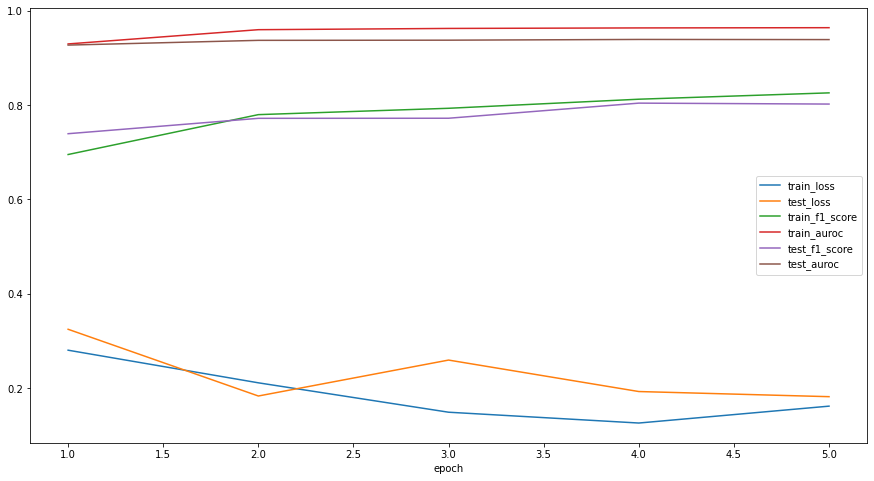

In [2]:
df = pd.read_csv('deeplabv3/results/log.csv')
df.plot(x='epoch',figsize=(15,8))

## Load dataset and sample images

In [3]:
batch_size=1

In [4]:
test_orig_img_shape = (768, 1024)

In [5]:
fd_val = FreiburgDataset("data/freiburg/val")
val_dataloader = torch.utils.data.DataLoader(fd_val, batch_size=batch_size, shuffle=True, collate_fn=cf)
val_img, val_mask = next(iter(val_dataloader))

fd_test = FreiburgTestDataset("data/freiburg/test")
test_dataloader = torch.utils.data.DataLoader(fd_test, batch_size=batch_size, shuffle=False)
test_img = next(iter(test_dataloader))

## Obtain semantic segmentation prediction with Deeplabv3

In [6]:
deeplabv3_model = torch.load('deeplabv3/results/deeplabv3_model.pt', map_location=torch.device('cpu')).to('cpu')
deeplabv3_model.eval()
_=1

In [7]:
with torch.no_grad():
    val_mask_pred = deeplabv3_model(val_img)['out']
    test_mask_pred = deeplabv3_model(test_img)['out']

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
val_img = dn(val_img)[0].transpose(1,2,0)
val_mask = dn(val_mask)[0]
val_mask_pred = dn(val_mask_pred)[0]

test_img = dn(test_img)[0].transpose(1,2,0)
test_mask_pred = dn(test_mask_pred)[0]

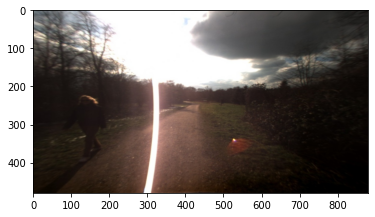

In [9]:
plt.imshow(test_img)

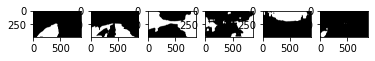

In [11]:
fig,axs=plt.subplots(1,6)
for i in range(6):
    axs[i].imshow(nut(test_mask_pred[i]), cmap='gray')

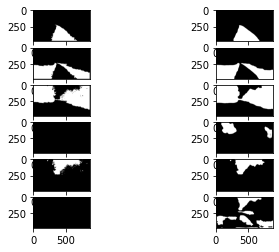

In [10]:
fig,axs=plt.subplots(6,2)
for i in range(6):
    axs[i,0].imshow(val_mask[i], cmap='gray')
    axs[i,1].imshow(nut(val_mask_pred[i]), cmap='gray')

In [8]:
fd_train.obj_names

['Road', 'Grass', 'Vegetation', 'Tree', 'Sky', 'Obstacle']

## Obtain depth prediction with monodepth2

In [ ]:
#change transform to match monodepth2's required size
fd_test.transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Resize((480, 640))])
test_dataloader = torch.utils.data.DataLoader(fd_test, batch_size=batch_size, shuffle=False)
test_img = next(iter(test_dataloader))

In [ ]:
from monodepth2 import estimate_depthmap

In [ ]:
test_depth_pred = estimate_depthmap(test_img)

## Obtain vegetation prediction

In [ ]:
#resize test_mask_pred and test_depth_pred back to 1024x768

In [13]:
test_mask_pred.shape

(6, 480, 880)

In [ ]:
from vegetation_index import vegetation_index

In [ ]:
val_veg = vegetation_index(test_mask_pred, test_depth_pred)